<a href="https://colab.research.google.com/github/likezhu7-prog/Classification-Assignment-/blob/main/model_comparison.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
# ===============================================
# 0. Imports
# ===============================================
import pandas as pd
import numpy as np
import torch

from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_predict
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import SGDClassifier
from xgboost import XGBClassifier

from transformers import AutoTokenizer, AutoModel
import seaborn as sns
import matplotlib.pyplot as plt

In [58]:
# ===============================================
# 1. Load dataset
# ===============================================
df = pd.read_csv("cancer_cleaned_trimmed.csv")
X = df["cleaned_text"].astype(str)
y = df["label"].astype(int)

In [59]:
# ===============================================
# 2. Train / Validation / Test split
# ===============================================
X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.40, random_state=42, stratify=y
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp
)

print("Train size:", len(X_train))
print("Validation size:", len(X_val))
print("Test size:", len(X_test))

Train size: 600
Validation size: 200
Test size: 200


In [60]:
# ===============================================
# 3. TF-IDF + Traditional Models (10-fold CV)
# ===============================================

tfidf = TfidfVectorizer(
    ngram_range=(1,2),
    min_df=3,
    max_df=0.9,
    sublinear_tf=True
)

models = {
    "SVM (LinearSVC)": LinearSVC(),
    "Random Forest": RandomForestClassifier(n_estimators=300, n_jobs=-1),
    "Naive Bayes": MultinomialNB(),
    "kNN": KNeighborsClassifier(n_neighbors=5, metric="cosine"),
    "XGBoost": XGBClassifier(
        n_estimators=300,
        learning_rate=0.1,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="multi:softmax",
        num_class=len(np.unique(y)),
        eval_metric="mlogloss",
        n_jobs=-1
    ),
    "SGD": SGDClassifier(loss="hinge", random_state=42)
}

pipelines = {
    name: Pipeline([
        ("tfidf", tfidf),
        ("clf", model)
    ])
    for name, model in models.items()
}

def evaluate_models(pipelines, X_train, y_train, cv=10):
    skf = StratifiedKFold(n_splits=cv, shuffle=True, random_state=42)

    results = []
    confusion_mats = {}

    for name, pipe in pipelines.items():
        print(f"\n=== Evaluating {name} ===")

        y_pred = cross_val_predict(pipe, X_train, y_train, cv=skf, n_jobs=-1)

        acc = accuracy_score(y_train, y_pred)
        prec = precision_score(y_train, y_pred, average="macro")
        f1 = f1_score(y_train, y_pred, average="macro")

        results.append({
            "Model": name,
            "Accuracy": acc,
            "Precision_macro": prec,
            "F1_macro": f1
        })

        confusion_mats[name] = confusion_matrix(y_train, y_pred)

        print(f"Accuracy: {acc:.4f}")
        print(f"Macro Precision: {prec:.4f}")
        print(f"Macro F1: {f1:.4f}")

    return pd.DataFrame(results), confusion_mats

results_df, confusion_mats = evaluate_models(pipelines, X_train, y_train)
print("\n=== Traditional Models Summary ===")
print(results_df.sort_values(by="F1_macro", ascending=False))


=== Evaluating SVM (LinearSVC) ===
Accuracy: 0.9483
Macro Precision: 0.9487
Macro F1: 0.9483

=== Evaluating Random Forest ===
Accuracy: 0.9417
Macro Precision: 0.9418
Macro F1: 0.9414

=== Evaluating Naive Bayes ===
Accuracy: 0.8733
Macro Precision: 0.8778
Macro F1: 0.8741

=== Evaluating kNN ===
Accuracy: 0.7433
Macro Precision: 0.7479
Macro F1: 0.7430

=== Evaluating XGBoost ===
Accuracy: 0.9333
Macro Precision: 0.9342
Macro F1: 0.9334

=== Evaluating SGD ===
Accuracy: 0.9400
Macro Precision: 0.9403
Macro F1: 0.9397

=== Traditional Models Summary ===
             Model  Accuracy  Precision_macro  F1_macro
0  SVM (LinearSVC)  0.948333         0.948743  0.948288
1    Random Forest  0.941667         0.941768  0.941437
5              SGD  0.940000         0.940291  0.939673
4          XGBoost  0.933333         0.934196  0.933437
2      Naive Bayes  0.873333         0.877837  0.874095
3              kNN  0.743333         0.747907  0.742987


In [61]:
# ===============================================
# 4. BERT: Prepare model
# ===============================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

bert_name = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(bert_name)
bert_model = AutoModel.from_pretrained(bert_name).to(device)
bert_model.eval()

Using device: cpu


Loading weights:   0%|          | 0/199 [00:00<?, ?it/s]

BertModel LOAD REPORT from: bert-base-uncased
Key                                        | Status     |  | 
-------------------------------------------+------------+--+-
cls.predictions.transform.LayerNorm.weight | UNEXPECTED |  | 
cls.predictions.transform.LayerNorm.bias   | UNEXPECTED |  | 
cls.predictions.bias                       | UNEXPECTED |  | 
cls.seq_relationship.bias                  | UNEXPECTED |  | 
cls.seq_relationship.weight                | UNEXPECTED |  | 
cls.predictions.transform.dense.weight     | UNEXPECTED |  | 
cls.predictions.transform.dense.bias       | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 768, padding_idx=0)
    (position_embeddings): Embedding(512, 768)
    (token_type_embeddings): Embedding(2, 768)
    (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0-11): 12 x BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=768, out_features=768, bias=True)
            (key): Linear(in_features=768, out_features=768, bias=True)
            (value): Linear(in_features=768, out_features=768, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=768, out_features=768, bias=True)
            (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
  

In [62]:
# ===============================================
# 5. BERT Encoding Function
# ===============================================
def bert_encode(texts, batch_size=16, max_length=256):
    all_embeddings = []
    if not isinstance(texts, (list, tuple)):
        texts = list(texts)

    with torch.no_grad():
        for i in range(0, len(texts), batch_size):
            batch = texts[i:i + batch_size]
            enc = tokenizer(
                batch, padding=True, truncation=True,
                max_length=max_length, return_tensors="pt"
            )
            enc = {k: v.to(device) for k, v in enc.items()}
            outputs = bert_model(**enc)
            cls_vec = outputs.last_hidden_state[:, 0, :].cpu().numpy()
            all_embeddings.append(cls_vec)

    return np.vstack(all_embeddings)

In [63]:
# ===============================================
# 6. BERT encode Train / Val / Test
# ===============================================
print("\nEncoding texts using BERT...")
X_train_bert = bert_encode(X_train)
X_val_bert = bert_encode(X_val)
X_test_bert = bert_encode(X_test)

print("BERT Train:", X_train_bert.shape)
print("BERT Val:", X_val_bert.shape)
print("BERT Test:", X_test_bert.shape)


Encoding texts using BERT...
BERT Train: (600, 768)
BERT Val: (200, 768)
BERT Test: (200, 768)


In [64]:
# ===============================================
# 7. BERT + Logistic Regression
# ===============================================
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import precision_score

clf_bert = LogisticRegression(max_iter=1000, n_jobs=-1, multi_class="multinomial")
clf_bert.fit(X_train_bert, y_train)

y_val_pred = clf_bert.predict(X_val_bert)
val_acc = accuracy_score(y_val, y_val_pred)
val_precision = precision_score(y_val, y_val_pred, average="macro")
val_f1 = f1_score(y_val, y_val_pred, average="macro")

print("\n=== BERT Validation Results ===")
print("Validation Accuracy:", round(val_acc, 4))
print("Validation Macro Precision:", round(val_precision, 4))
print("Validation Macro F1:", round(val_f1, 4))
print("\nValidation classification report:")
print(classification_report(y_val, y_val_pred, digits=3))


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== BERT Validation Results ===
Validation Accuracy: 0.855
Validation Macro Precision: 0.8686
Validation Macro F1: 0.8578

Validation classification report:
              precision    recall  f1-score   support

           0      0.720     0.900     0.800        40
           1      0.800     0.800     0.800        40
           2      1.000     0.825     0.904        40
           3      0.850     0.850     0.850        40
           4      0.973     0.900     0.935        40

    accuracy                          0.855       200
   macro avg      0.869     0.855     0.858       200
weighted avg      0.869     0.855     0.858       200



In [65]:
# ===============================================
# 8. Final training on Train+Val, test on Test (BERT)
# ===============================================

from sklearn.metrics import precision_score

X_trainval_bert = np.vstack([X_train_bert, X_val_bert])
y_trainval = pd.concat([y_train, y_val])

clf_bert_final = LogisticRegression(
    max_iter=1000,
    n_jobs=-1,
    multi_class="multinomial"
)
clf_bert_final.fit(X_trainval_bert, y_trainval)

# Test evaluation for BERT
y_test_pred_bert = clf_bert_final.predict(X_test_bert)

bert_test_acc = accuracy_score(y_test, y_test_pred_bert)
bert_test_precision = precision_score(y_test, y_test_pred_bert, average="macro")
bert_test_f1 = f1_score(y_test, y_test_pred_bert, average="macro")

print("\n=== BERT Test Results ===")
print("Test Accuracy:", round(bert_test_acc, 4))
print("Test Macro Precision:", round(bert_test_precision, 4))
print("Test Macro F1:", round(bert_test_f1, 4))
print("\nClassification Report (Test):")
print(classification_report(y_test, y_test_pred_bert, digits=3))



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(



=== BERT Test Results ===
Test Accuracy: 0.795
Test Macro Precision: 0.8016
Test Macro F1: 0.7976

Classification Report (Test):
              precision    recall  f1-score   support

           0      0.675     0.675     0.675        40
           1      0.780     0.800     0.790        40
           2      0.946     0.875     0.909        40
           3      0.659     0.725     0.690        40
           4      0.947     0.900     0.923        40

    accuracy                          0.795       200
   macro avg      0.802     0.795     0.798       200
weighted avg      0.802     0.795     0.798       200



In [66]:
# ===============================================
# 9. Model Selection Table (for choosing champion model)
# ===============================================

# Traditional models: 10-fold CV on Train
# BERT: performance on Validation set

model_selection_df = results_df.copy()
model_selection_df["Source"] = "CV on Train"

bert_selection_row = {
    "Model": "BERT + Logistic Regression",
    "Accuracy": val_acc,
    "Precision_macro": val_precision,
    "F1_macro": val_f1,
    "Source": "Validation"
}

model_selection_df = pd.concat(
    [model_selection_df, pd.DataFrame([bert_selection_row])],
    ignore_index=True
)

print("\n=== Model Selection ===")
print(model_selection_df.sort_values(by="F1_macro", ascending=False))



=== Model Selection ===
                        Model  Accuracy  Precision_macro  F1_macro  \
0             SVM (LinearSVC)  0.948333         0.948743  0.948288   
1               Random Forest  0.941667         0.941768  0.941437   
5                         SGD  0.940000         0.940291  0.939673   
4                     XGBoost  0.933333         0.934196  0.933437   
2                 Naive Bayes  0.873333         0.877837  0.874095   
6  BERT + Logistic Regression  0.855000         0.868595  0.857835   
3                         kNN  0.743333         0.747907  0.742987   

        Source  
0  CV on Train  
1  CV on Train  
5  CV on Train  
4  CV on Train  
2  CV on Train  
6   Validation  
3  CV on Train  


In [68]:
# ===============================================
# Final Testing for ALL MODELS (Train+Val -> Test)
# ===============================================

final_test_results = []

models_for_test = {
    "SVM (LinearSVC)": LinearSVC(),
    "Random Forest": RandomForestClassifier(),
    "Naive Bayes": MultinomialNB(),
    "kNN": KNeighborsClassifier(),
    "SGD": SGDClassifier(),
    "XGBoost": XGBClassifier(eval_metric="mlogloss")
}

for name, model in models_for_test.items():
    pipe = Pipeline([
        ("tfidf", TfidfVectorizer(
            ngram_range=(1,2),
            min_df=3,
            max_df=0.9,
            sublinear_tf=True
        )),
        ("clf", model)
    ])

    pipe.fit(X_trainval, y_trainval)
    pred = pipe.predict(X_test)

    final_test_results.append({
        "Model": name,
        "Test_Accuracy": accuracy_score(y_test, pred),
        "Test_F1_macro": f1_score(y_test, pred, average="macro")
    })

# Add BERT
final_test_results.append({
    "Model": "BERT + Logistic Regression",
    "Test_Accuracy": bert_test_acc,
    "Test_F1_macro": bert_test_f1
})

final_test_df = pd.DataFrame(final_test_results)
print("\n=== Final Testing for ALL MODELS ===")
print(final_test_df.sort_values(by="Test_F1_macro", ascending=False))


=== Final Testing for ALL MODELS ===
                        Model  Test_Accuracy  Test_F1_macro
1               Random Forest          0.950       0.950055
0             SVM (LinearSVC)          0.950       0.949649
4                         SGD          0.935       0.934785
5                     XGBoost          0.930       0.929866
2                 Naive Bayes          0.885       0.887464
3                         kNN          0.815       0.815136
6  BERT + Logistic Regression          0.795       0.797553


In [69]:
# ===== Final Testing for Champion Model: SVM =====

from sklearn.svm import LinearSVC
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline

svm_champion = Pipeline([
    ("tfidf", TfidfVectorizer(
        ngram_range=(1,2),
        min_df=3,
        max_df=0.9,
        sublinear_tf=True
    )),
    ("clf", LinearSVC())
])

# Train + Validation
X_trainval = pd.concat([X_train, X_val])
y_trainval = pd.concat([y_train, y_val])

# Train champion
svm_champion.fit(X_trainval, y_trainval)

# Final Test predictions
y_test_pred_svm = svm_champion.predict(X_test)

# Metrics
from sklearn.metrics import accuracy_score, precision_score, f1_score, classification_report

test_acc_svm = accuracy_score(y_test, y_test_pred_svm)
test_precision_svm = precision_score(y_test, y_test_pred_svm, average="macro")
test_f1_svm = f1_score(y_test, y_test_pred_svm, average="macro")

print("=== Final Test Results: SVM (Champion Model) ===")
print("Test Accuracy:", test_acc_svm)
print("Test Macro Precision:", test_precision_svm)
print("Test Macro F1:", test_f1_svm)
print("\nClassification Report:\n")
print(classification_report(y_test, y_test_pred_svm, digits=3))


=== Final Test Results: SVM (Champion Model) ===
Test Accuracy: 0.95
Test Macro Precision: 0.9504733493474277
Test Macro F1: 0.9496486504343249

Classification Report:

              precision    recall  f1-score   support

           0      0.974     0.950     0.962        40
           1      0.927     0.950     0.938        40
           2      0.975     0.975     0.975        40
           3      0.946     0.875     0.909        40
           4      0.930     1.000     0.964        40

    accuracy                          0.950       200
   macro avg      0.950     0.950     0.950       200
weighted avg      0.950     0.950     0.950       200



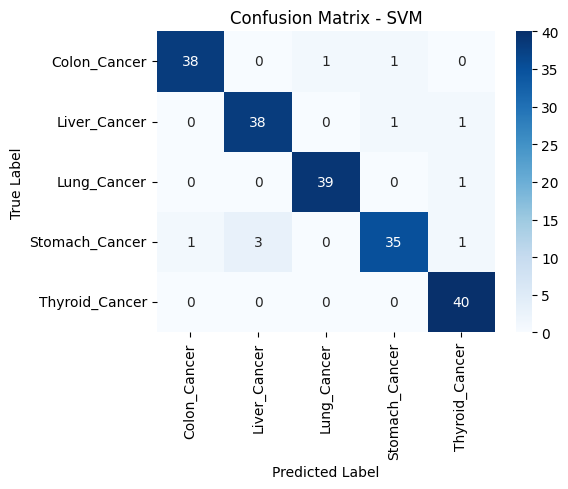

In [70]:
# ===== Confusion Matrix for SVM =====
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_test_pred_svm)

class_names = ["Colon_Cancer", "Liver_Cancer", "Lung_Cancer", "Stomach_Cancer", "Thyroid_Cancer"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d",
            xticklabels=class_names,
            yticklabels=class_names,
            cmap="Blues")
plt.title("Confusion Matrix - SVM")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()


# Error Analysis + SHAP

In [71]:
# ===============================================
# Load No-Keywords Data
# ===============================================

# Load data with disease names removed
df_no_kw = pd.read_csv("cancer_cleaned_v2_trimmed.csv")

# Use same indices as original split
X_train_no_kw = df_no_kw["cleaned_text"].iloc[X_train.index].astype(str)
X_val_no_kw = df_no_kw["cleaned_text"].iloc[X_val.index].astype(str)
X_test_no_kw = df_no_kw["cleaned_text"].iloc[X_test.index].astype(str)

# Verify labels are the same
assert (df_no_kw.iloc[X_train.index, 0].values == y_train.values).all()
assert (df_no_kw.iloc[X_test.index, 0].values == y_test.values).all()

X_trainval_no_kw = pd.concat([X_train_no_kw, X_val_no_kw])

print("No-keywords data loaded successfully!")
print(f"Train+Val size: {len(X_trainval_no_kw)}")
print(f"Test size: {len(X_test_no_kw)}")

No-keywords data loaded successfully!
Train+Val size: 800
Test size: 200


In [72]:
# ===============================================
# Train SVM on No-Keywords Data
# ===============================================

# Train identical pipeline on no-keywords data
svm_no_kw = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, sublinear_tf=True)),
    ("clf", LinearSVC())
])

svm_no_kw.fit(X_trainval_no_kw, y_trainval)
y_pred_no_kw = svm_no_kw.predict(X_test_no_kw)

# Accuracy comparison
acc_orig = accuracy_score(y_test, y_test_pred_svm)
acc_no_kw = accuracy_score(y_test, y_pred_no_kw)
acc_drop = (acc_orig - acc_no_kw) / acc_orig * 100

print("=== Accuracy Comparison ===")
print(f"Original Data:   {acc_orig:.2%}")
print(f"No Keywords:    {acc_no_kw:.2%}")
print(f"Accuracy Drop:  {acc_drop:.1f}%")

=== Accuracy Comparison ===
Original Data:   95.00%
No Keywords:    68.50%
Accuracy Drop:  27.9%


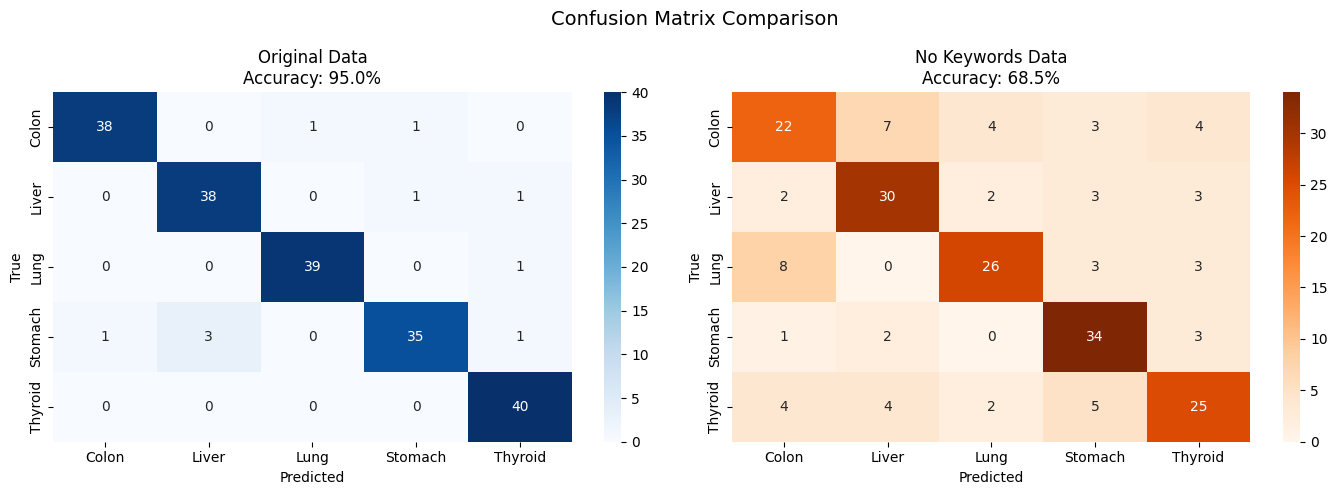


Misclassified samples: 63 / 200 (31.5%)


In [73]:
# ===============================================
# Confusion Matrix Comparison
# ===============================================

cm_no_kw = confusion_matrix(y_test, y_pred_no_kw)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Original
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", ax=axes[0],
            xticklabels=["Colon", "Liver", "Lung", "Stomach", "Thyroid"],
            yticklabels=["Colon", "Liver", "Lung", "Stomach", "Thyroid"])
axes[0].set_title(f"Original Data\nAccuracy: {acc_orig:.1%}", fontsize=12)
axes[0].set_xlabel("Predicted")
axes[0].set_ylabel("True")

# No Keywords
sns.heatmap(cm_no_kw, annot=True, fmt="d", cmap="Oranges", ax=axes[1],
            xticklabels=["Colon", "Liver", "Lung", "Stomach", "Thyroid"],
            yticklabels=["Colon", "Liver", "Lung", "Stomach", "Thyroid"])
axes[1].set_title(f"No Keywords Data\nAccuracy: {acc_no_kw:.1%}", fontsize=12)
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.suptitle("Confusion Matrix Comparison", fontsize=14)
plt.tight_layout()
plt.savefig("confusion_matrix_comparison.png", dpi=150, bbox_inches='tight')
plt.show()

# Error analysis
errors = X_test[y_test != y_pred_no_kw]
print(f"\nMisclassified samples: {len(errors)} / {len(X_test)} ({len(errors)/len(X_test):.1%})")

=== 10-Fold CV Variability ===
Original:   Mean=94.88%, Std=2.82%
No Keywd:   Mean=64.00%, Std=6.14%


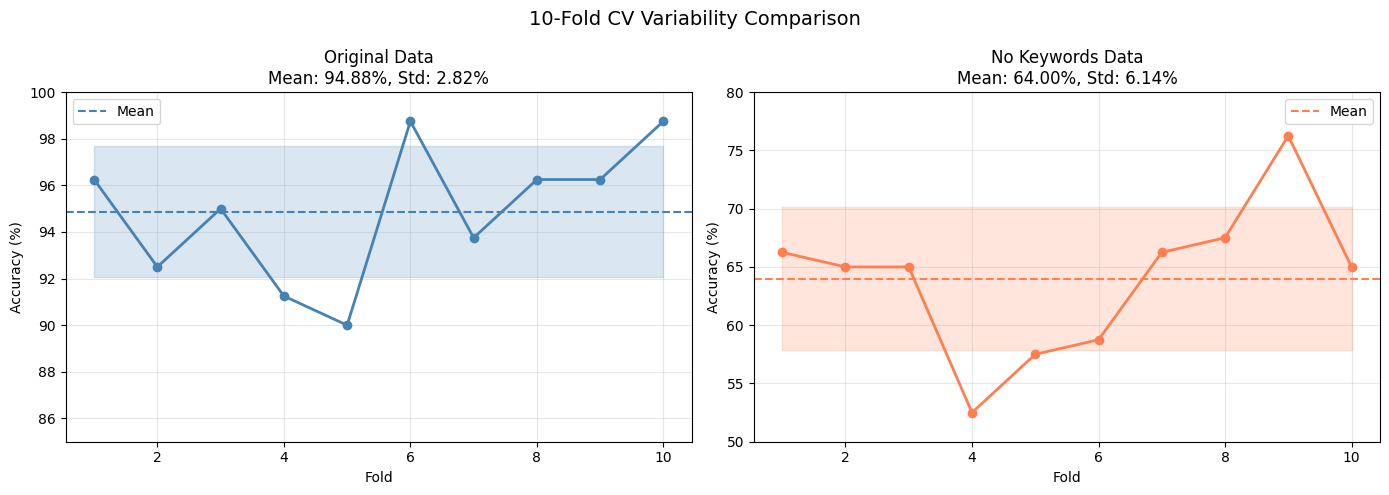

In [74]:
# ===============================================
# 10-Fold CV Variability Comparison
# ===============================================

from sklearn.model_selection import cross_val_score

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# CV on original
cv_pipeline_orig = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, sublinear_tf=True)),
    ("clf", LinearSVC())
])
cv_scores_orig = cross_val_score(cv_pipeline_orig, X_trainval, y_trainval, cv=skf, scoring='accuracy')

# CV on no-keywords
cv_pipeline_no_kw = Pipeline([
    ("tfidf", TfidfVectorizer(ngram_range=(1,2), min_df=3, max_df=0.9, sublinear_tf=True)),
    ("clf", LinearSVC())
])
cv_scores_no_kw = cross_val_score(cv_pipeline_no_kw, X_trainval_no_kw, y_trainval, cv=skf, scoring='accuracy')

print("=== 10-Fold CV Variability ===")
print(f"Original:   Mean={cv_scores_orig.mean():.2%}, Std={cv_scores_orig.std():.2%}")
print(f"No Keywd:   Mean={cv_scores_no_kw.mean():.2%}, Std={cv_scores_no_kw.std():.2%}")

# Plot
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].plot(range(1, 11), cv_scores_orig*100, 'o-', color='steelblue', linewidth=2)
axes[0].axhline(y=cv_scores_orig.mean()*100, color='steelblue', linestyle='--', label='Mean')
axes[0].fill_between(range(1, 11),
                    (cv_scores_orig.mean()-cv_scores_orig.std())*100,
                    (cv_scores_orig.mean()+cv_scores_orig.std())*100, alpha=0.2, color='steelblue')
axes[0].set_xlabel('Fold')
axes[0].set_ylabel('Accuracy (%)')
axes[0].set_title(f'Original Data\nMean: {cv_scores_orig.mean():.2%}, Std: {cv_scores_orig.std():.2%}')
axes[0].set_ylim(85, 100)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].plot(range(1, 11), cv_scores_no_kw*100, 'o-', color='coral', linewidth=2)
axes[1].axhline(y=cv_scores_no_kw.mean()*100, color='coral', linestyle='--', label='Mean')
axes[1].fill_between(range(1, 11),
                    (cv_scores_no_kw.mean()-cv_scores_no_kw.std())*100,
                    (cv_scores_no_kw.mean()+cv_scores_no_kw.std())*100, alpha=0.2, color='coral')
axes[1].set_xlabel('Fold')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title(f'No Keywords Data\nMean: {cv_scores_no_kw.mean():.2%}, Std: {cv_scores_no_kw.std():.2%}')
axes[1].set_ylim(50, 80)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.suptitle('10-Fold CV Variability Comparison', fontsize=14)
plt.tight_layout()
plt.savefig('cv_variability.png', dpi=150, bbox_inches='tight')
plt.show()

In [75]:
# Import SHAP library
import shap

In [76]:
# ===============================================
# SHAP Analysis
# ===============================================

# Get TF-IDF features from original model
vectorizer_orig = svm_champion.named_steps['tfidf']
clf_orig = svm_champion.named_steps['clf']
X_test_tfidf = vectorizer_orig.transform(X_test)
feature_names = np.array(vectorizer_orig.get_feature_names_out())

print("Computing SHAP values...")
explainer = shap.LinearExplainer(clf_orig, X_test_tfidf)
shap_values = explainer.shap_values(X_test_tfidf)

# Feature importance
mean_abs_shap = np.abs(shap_values).mean(axis=0)
if len(mean_abs_shap.shape) > 1:
    mean_abs_shap = mean_abs_shap.mean(axis=1)

top_indices = np.argsort(mean_abs_shap)[-20:][::-1]
top_features_orig = [feature_names[i] for i in top_indices]
top_values_orig = mean_abs_shap[top_indices]

print("\n=== Top 15 Features (Original Data) ===")
for i, (f, v) in enumerate(zip(top_features_orig[:15], top_values_orig[:15])):
    print(f"{i+1}. {f}: {v:.4f}")

Computing SHAP values...

=== Top 15 Features (Original Data) ===
1. thyroid: 0.1261
2. lung: 0.1163
3. colon: 0.0950
4. liver: 0.0833
5. stomach: 0.0685
6. gastric: 0.0320
7. colorectal: 0.0183
8. hcc: 0.0130
9. rectal: 0.0082
10. metastasis: 0.0078
11. survival: 0.0076
12. non: 0.0075
13. cell: 0.0075
14. carcinoma: 0.0074
15. colon cell: 0.0071


<Figure size 1200x1000 with 0 Axes>

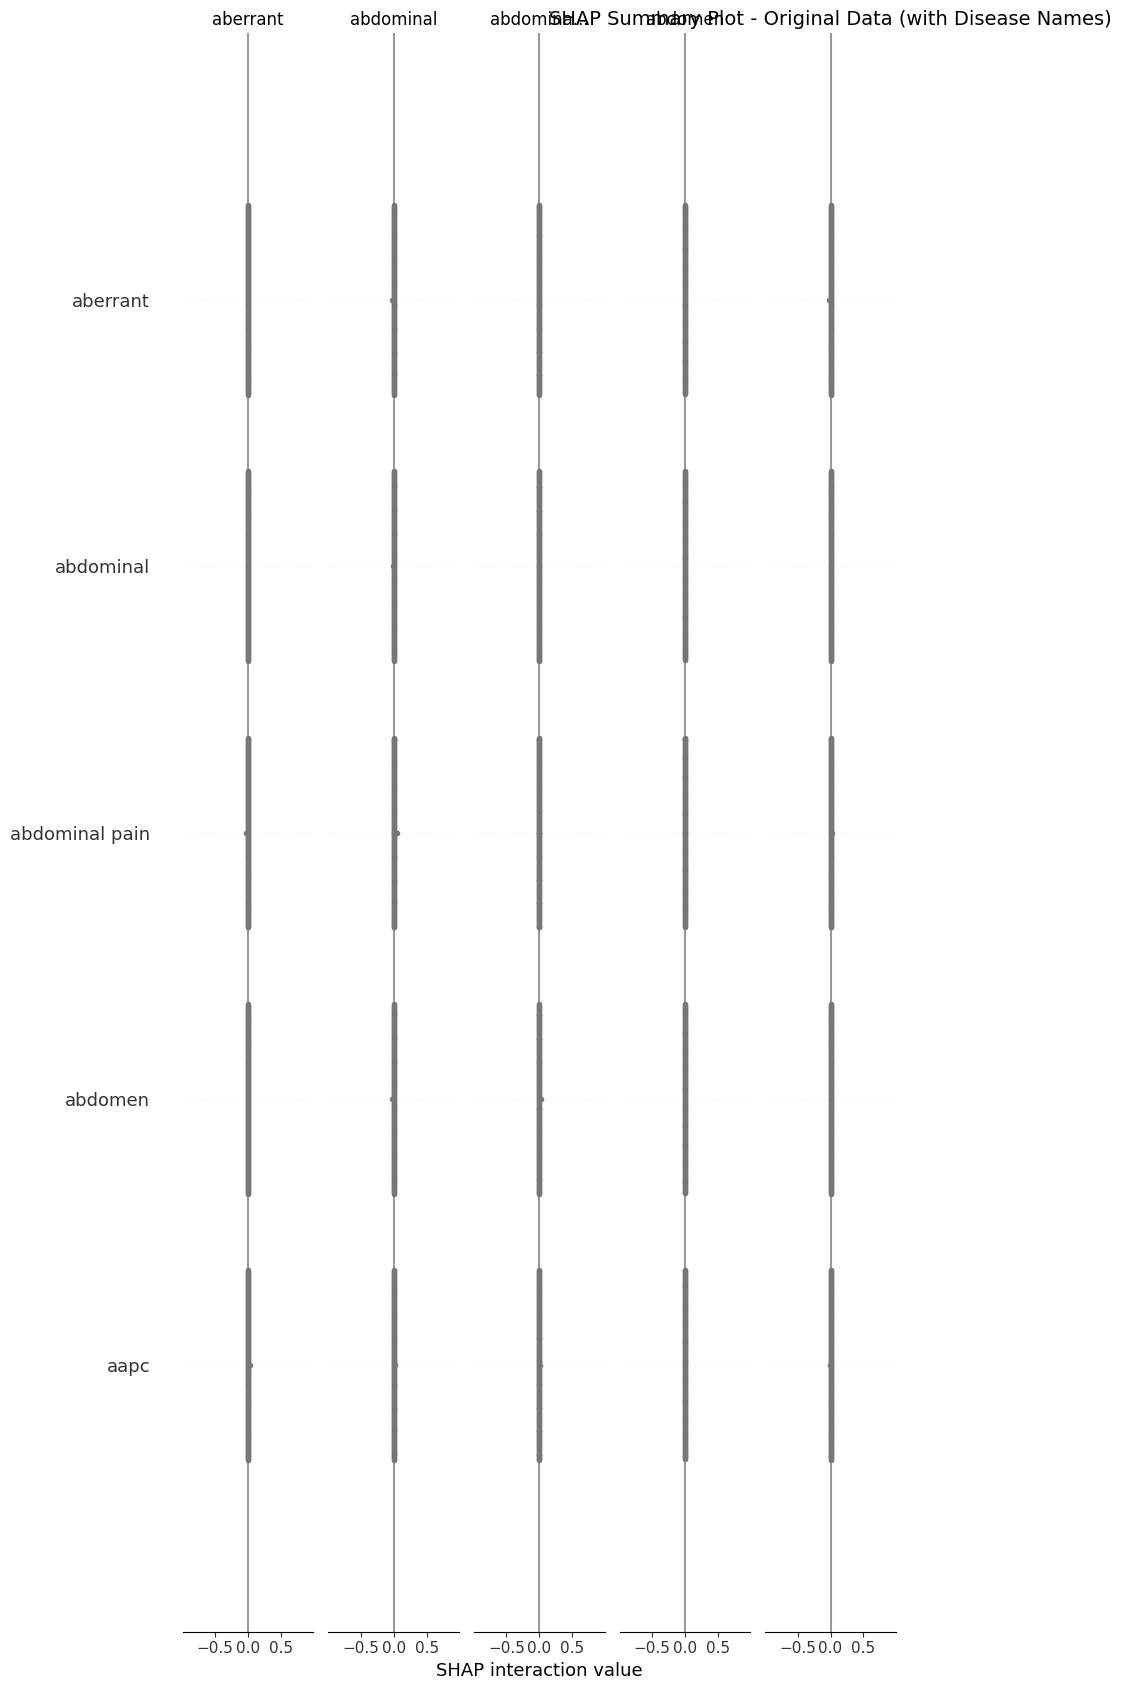

In [77]:
# SHAP Summary Plot
plt.figure(figsize=(12, 10))
shap.summary_plot(shap_values, X_test_tfidf, feature_names=feature_names, max_display=20, show=False)
plt.title('SHAP Summary Plot - Original Data (with Disease Names)', fontsize=14)
plt.tight_layout()
plt.savefig('shap_summary_original.png', dpi=150, bbox_inches='tight')
plt.show()

In [78]:
# ===============================================
# SHAP Feature Importance Comparison
# ===============================================

# SHAP for no-keywords data
vectorizer_no_kw = svm_no_kw.named_steps['tfidf']
clf_no_kw = svm_no_kw.named_steps['clf']
X_test_tfidf_no_kw = vectorizer_no_kw.transform(X_test_no_kw)
feature_names_no_kw = np.array(vectorizer_no_kw.get_feature_names_out())

explainer_no_kw = shap.LinearExplainer(clf_no_kw, X_test_tfidf_no_kw)
shap_values_no_kw = explainer_no_kw.shap_values(X_test_tfidf_no_kw)

mean_abs_shap_no_kw = np.abs(shap_values_no_kw).mean(axis=0)
if len(mean_abs_shap_no_kw.shape) > 1:
    mean_abs_shap_no_kw = mean_abs_shap_no_kw.mean(axis=1)

top_indices_no_kw = np.argsort(mean_abs_shap_no_kw)[-20:][::-1]
top_features_no_kw = [feature_names_no_kw[i] for i in top_indices_no_kw]
top_values_no_kw = mean_abs_shap_no_kw[top_indices_no_kw]

print("\n=== Top 15 Features (No Keywords Data) ===")
for i, (f, v) in enumerate(zip(top_features_no_kw[:15], top_values_no_kw[:15])):
    print(f"{i+1}. {f}: {v:.4f}")


=== Top 15 Features (No Keywords Data) ===
1. metastasis: 0.0205
2. carcinoma: 0.0190
3. cell: 0.0182
4. mortality: 0.0156
5. non: 0.0148
6. survival: 0.0137
7. small: 0.0137
8. small cell: 0.0128
9. adenocarcinoma: 0.0126
10. stage: 0.0116
11. ptc: 0.0114
12. association: 0.0114
13. nodule: 0.0106
14. associate: 0.0105
15. non small: 0.0103


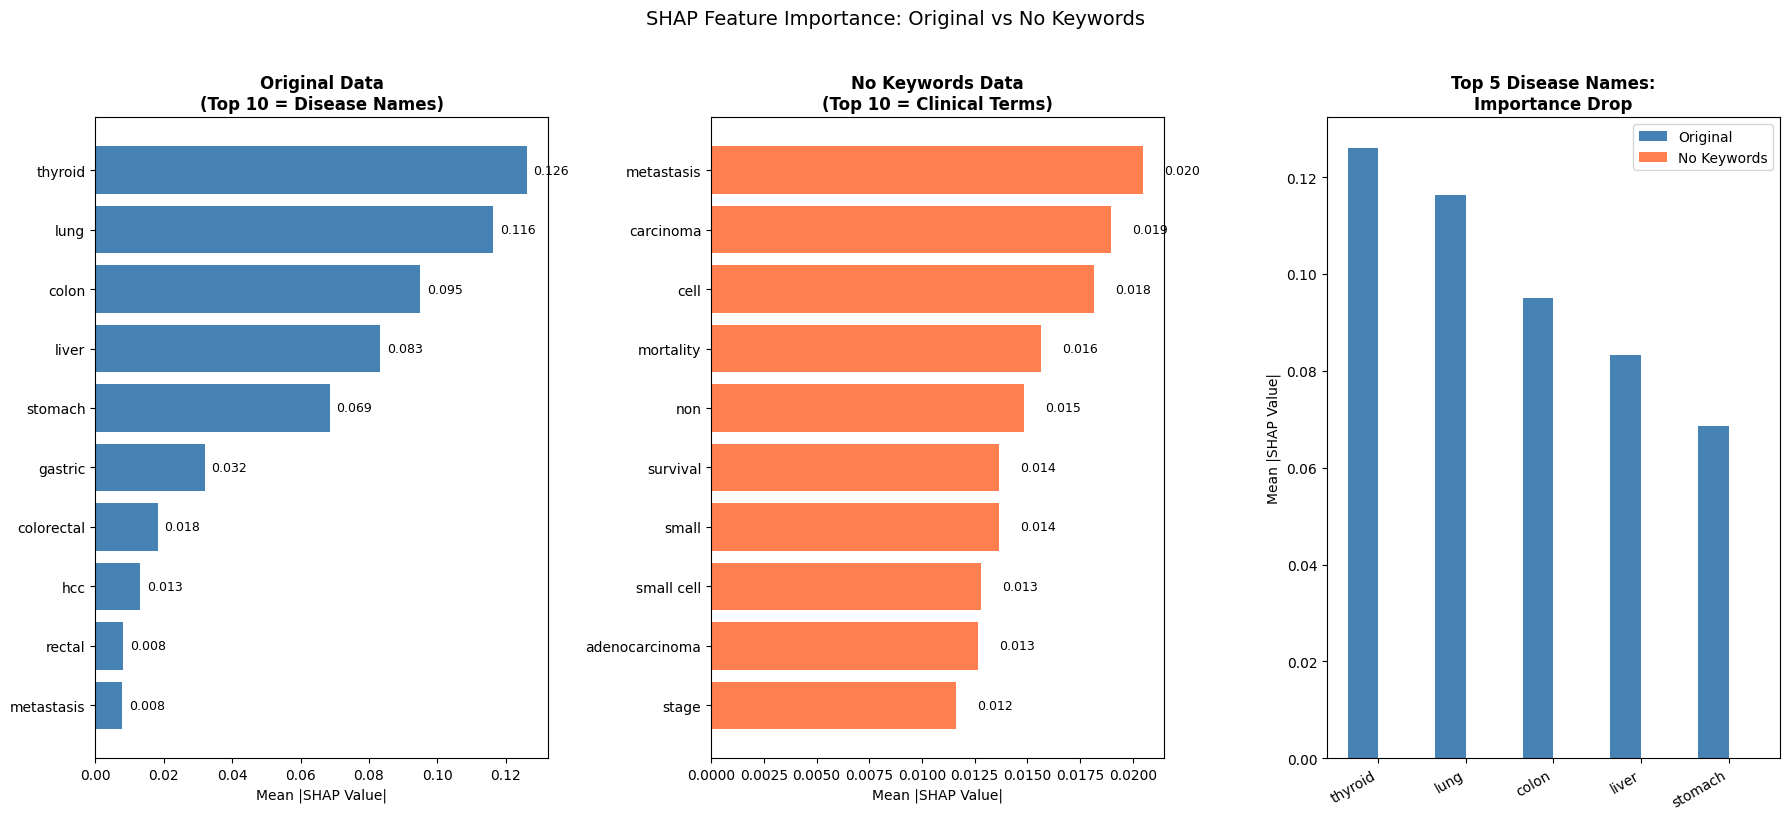

In [79]:
# Feature Importance Comparison Plot (3 panels)
fig, axes = plt.subplots(1, 3, figsize=(18, 8))

# Left: Original Top 10
ax1 = axes[0]
y_pos1 = np.arange(10)
ax1.barh(y_pos1, top_values_orig[:10][::-1], color='steelblue')
for k, bar in enumerate(ax1.patches):
    ax1.text(top_values_orig[9-k] + 0.002, bar.get_y() + bar.get_height()/2,
            f'{top_values_orig[9-k]:.3f}', va='center', fontsize=9)
ax1.set_yticks(y_pos1)
ax1.set_yticklabels(top_features_orig[:10][::-1])
ax1.set_xlabel('Mean |SHAP Value|')
ax1.set_title('Original Data\n(Top 10 = Disease Names)', fontweight='bold')

# Middle: No Keywords Top 10
ax2 = axes[1]
y_pos2 = np.arange(10)
ax2.barh(y_pos2, top_values_no_kw[:10][::-1], color='coral')
for k, bar in enumerate(ax2.patches):
    ax2.text(top_values_no_kw[9-k] + 0.001, bar.get_y() + bar.get_height()/2,
            f'{top_values_no_kw[9-k]:.3f}', va='center', fontsize=9)
ax2.set_yticks(y_pos2)
ax2.set_yticklabels(top_features_no_kw[:10][::-1])
ax2.set_xlabel('Mean |SHAP Value|')
ax2.set_title('No Keywords Data\n(Top 10 = Clinical Terms)', fontweight='bold')

# Right: Top 5 disease names importance drop
ax3 = axes[2]
top5_disease = top_features_orig[:5]
vals_orig = [mean_abs_shap[np.where(feature_names == f)[0][0]] if f in feature_names else 0 for f in top5_disease]
vals_no_kw = [mean_abs_shap_no_kw[np.where(feature_names_no_kw == f)[0][0]] if f in feature_names_no_kw else 0 for f in top5_disease]

x = np.arange(5)
width = 0.35
ax3.bar(x - width/2, vals_orig, width, label='Original', color='steelblue')
ax3.bar(x + width/2, vals_no_kw, width, label='No Keywords', color='coral')
ax3.set_xticks(x)
ax3.set_xticklabels(top5_disease, rotation=30, ha='right')
ax3.set_ylabel('Mean |SHAP Value|')
ax3.set_title('Top 5 Disease Names:\nImportance Drop', fontweight='bold')
ax3.legend()

plt.suptitle('SHAP Feature Importance: Original vs No Keywords', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('shap_feature_importance_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

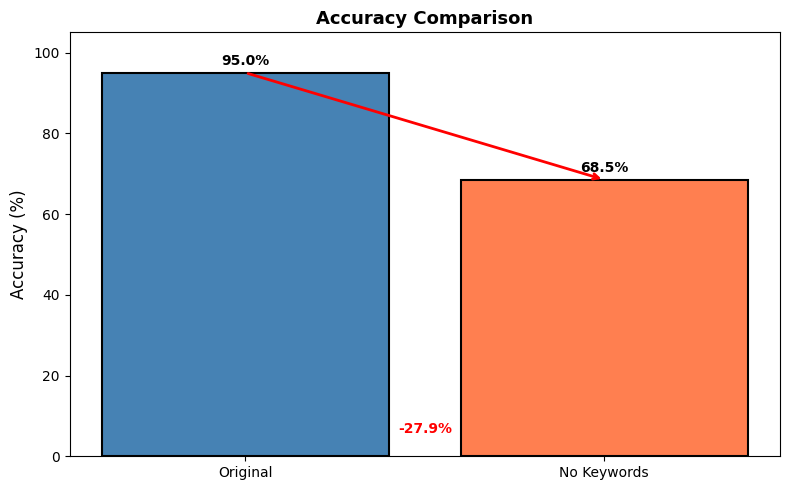

In [ ]:
# ===============================================
# Accuracy Comparison Plot
# ===============================================

fig, ax = plt.subplots(figsize=(8, 5))

bars = ax.bar(['Original', 'No Keywords'], [acc_orig*100, acc_no_kw*100],
            color=['steelblue', 'coral'], edgecolor='black', linewidth=1.5)
ax.set_ylabel('Accuracy (%)', fontsize=12)
ax.set_title('Accuracy Comparison', fontsize=13, fontweight='bold')
ax.set_ylim(0, 105)
for i, v in enumerate([acc_orig*100, acc_no_kw*100]):
    ax.text(i, v + 2, f'{v:.1f}%', ha='center', fontweight='bold')

# Drop arrow
ax.annotate('', xy=(1, acc_no_kw*100), xytext=(0, acc_orig*100),
            arrowprops=dict(arrowstyle='->', color='red', lw=2))
ax.text(0.5, (acc_orig + acc_no_kw)/2 + 5, f'-{acc_drop:.1f}%',
        ha='center', color='red', fontweight='bold')

plt.tight_layout()
plt.savefig('accuracy_comparison.png', dpi=150)
plt.show()

In [ ]:
# Import label_binarize
from sklearn.preprocessing import label_binarize

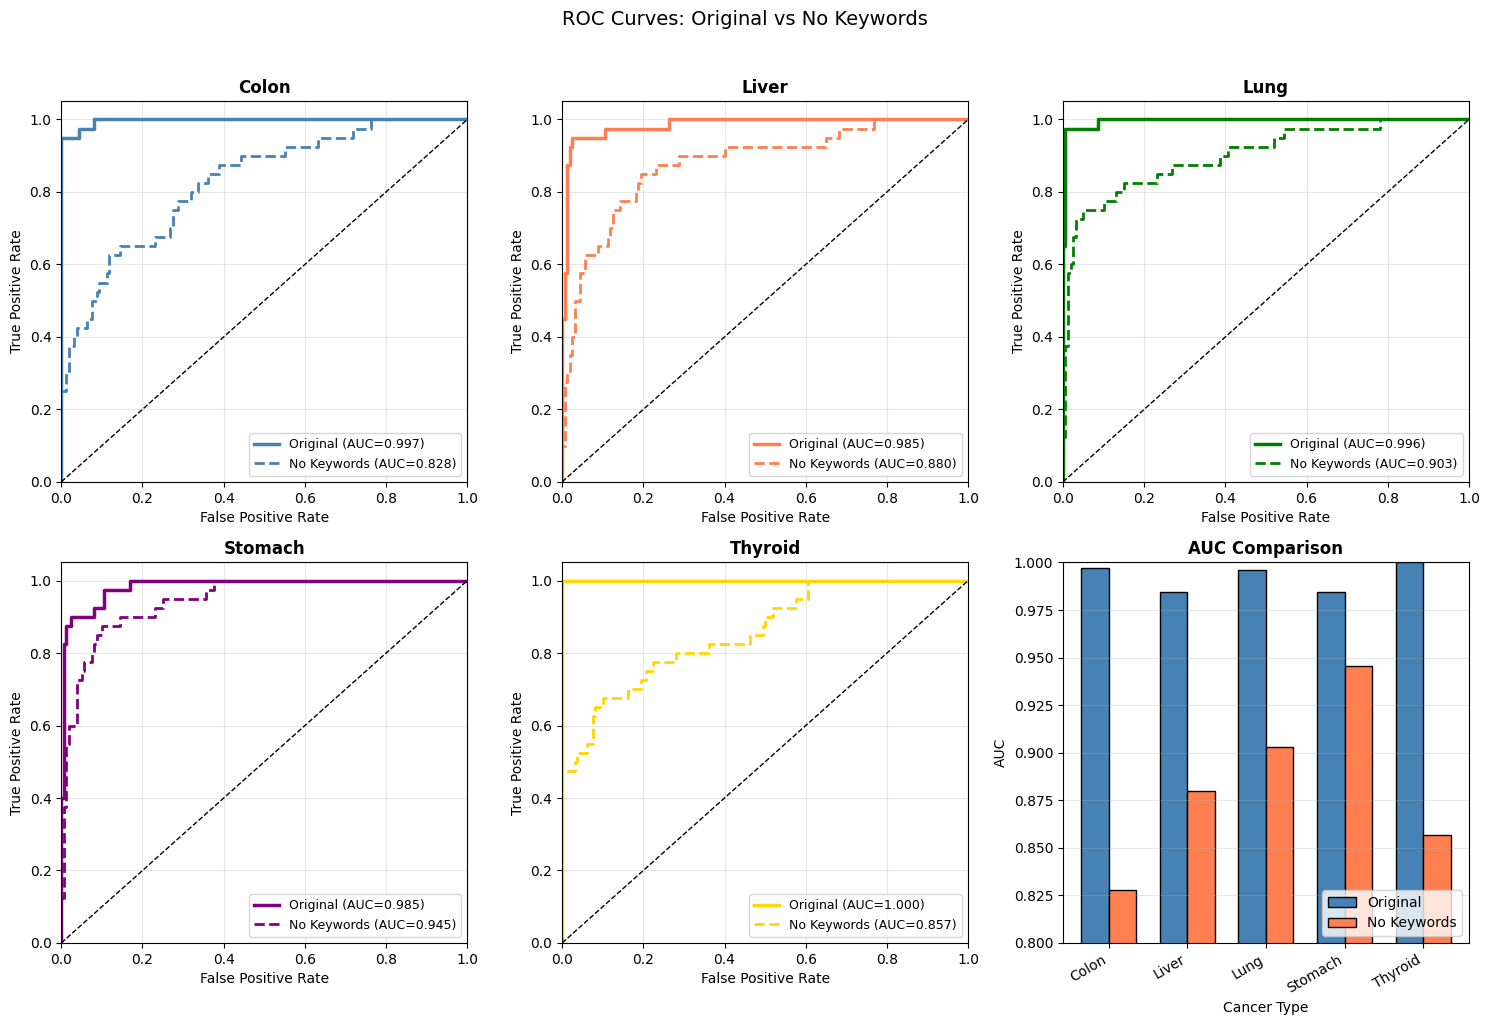


=== AUC Comparison ===
Colon: Original=0.997, No Keywords=0.828, Drop=0.169
Liver: Original=0.985, No Keywords=0.880, Drop=0.105
Lung: Original=0.996, No Keywords=0.903, Drop=0.093
Stomach: Original=0.985, No Keywords=0.945, Drop=0.039
Thyroid: Original=1.000, No Keywords=0.857, Drop=0.143


In [ ]:
# ===============================================
# Part 3.8: ROC Curves and AUC
# ===============================================

# Get decision functions
from sklearn.metrics import roc_curve, auc
decision_orig = clf_orig.decision_function(X_test_tfidf)
decision_no_kw = clf_no_kw.decision_function(X_test_tfidf_no_kw)
y_test_bin = label_binarize(y_test, classes=[0, 1, 2, 3, 4])

fig = plt.figure(figsize=(15, 10))
label_names = ['Colon', 'Liver', 'Lung', 'Stomach', 'Thyroid']
colors = ['steelblue', 'coral', 'green', 'purple', 'gold']

auc_orig_list = []
auc_no_kw_list = []

for i in range(5):
    ax = fig.add_subplot(2, 3, i+1)

    fpr_o, tpr_o, _ = roc_curve(y_test_bin[:, i], decision_orig[:, i])
    auc_o = auc(fpr_o, tpr_o)
    auc_orig_list.append(auc_o)
    ax.plot(fpr_o, tpr_o, color=colors[i], lw=2.5, label=f'Original (AUC={auc_o:.3f})')

    fpr_n, tpr_n, _ = roc_curve(y_test_bin[:, i], decision_no_kw[:, i])
    auc_n = auc(fpr_n, tpr_n)
    auc_no_kw_list.append(auc_n)
    ax.plot(fpr_n, tpr_n, color=colors[i], lw=2, linestyle='--', label=f'No Keywords (AUC={auc_n:.3f})')

    ax.plot([0, 1], [0, 1], 'k--', lw=1)
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate')
    ax.set_ylabel('True Positive Rate')
    ax.set_title(label_names[i], fontweight='bold')
    ax.legend(loc='lower right', fontsize=9)
    ax.grid(True, alpha=0.3)

# AUC comparison bar chart
ax_bar = fig.add_subplot(2, 3, 6)
x = np.arange(5)
width = 0.35
ax_bar.bar(x - width/2, auc_orig_list, width, label='Original', color='steelblue', edgecolor='black')
ax_bar.bar(x + width/2, auc_no_kw_list, width, label='No Keywords', color='coral', edgecolor='black')
ax_bar.set_xticks(x)
ax_bar.set_xticklabels(label_names, rotation=30, ha='right')
ax_bar.set_xlabel('Cancer Type')
ax_bar.set_ylabel('AUC')
ax_bar.set_title('AUC Comparison', fontweight='bold')
ax_bar.set_ylim(0.8, 1.0)
ax_bar.legend(loc='lower right')
ax_bar.grid(True, alpha=0.3, axis='y')

plt.suptitle('ROC Curves: Original vs No Keywords', fontsize=14, y=1.02)
plt.tight_layout()
plt.savefig('roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n=== AUC Comparison ===")
for i, name in enumerate(label_names):
    print(f"{name}: Original={auc_orig_list[i]:.3f}, No Keywords={auc_no_kw_list[i]:.3f}, Drop={auc_orig_list[i]-auc_no_kw_list[i]:.3f}")